# [Predictive Modeling]


### Goal of Prediction
* The goal is to predict whether the stock price will go up or down in 100 business days based on attributes such as sentiment on short recommendation articles, firm size of the stocks, utilization, characteristics of the short articles and so on.

### Features
* y: sign of 100-day holding period return (100d_ret)
> * y = 1 if 100d_ret < 0 (correct short recommendation)
> * y = 0 if 100d_ret >= 0 (wrong short recommendation)
* X: firm size, utilization (ratio of shorted shares to lendable shares), article sentiments, characteristics of the short articles

### Data time period
* Training set: 2012Q1 - 2015Q3
* Test set: 2015Q4 - 2016Q2

### Performance Measure of Prediction
* Precision: TP / (FP+TP)

### Binary Classifiers
* Dummy Classifier (baseline model)
* Logistic Regression
* Random Forests
* Extra-Trees
* AdaBoost
* Gradient Boosting
* XGBoost
* SVC (Support Vector Classification)
* MLP (Multilayer Perceptron)

### Methods
1. For each model, perform "time-series cross validation" -> Calculate average and std.dev. of precisions from each validation sets -> Select best models.
> The goal of time series forecasting is to make accurate predictions about the future. The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem. Therefore, time-series cross validation illustrated in the graph will be used in this project.
2. Fine-tune hyperparameters of the selected models using RandomizedSearchCV to improve the performance -> Make predictions on the test set.
3. Try to ensemble the best models using various methods such as hard/soft voting and stacking -> Make predictions on the test set.
4. Compare the performance of predictions of the individual models and ensemble methods.

### Performance of predictive modeling: cumulative return comparison
* Time period: 2015Q4 - 2016Q2
* Market Index
* Shorting all SA short recommended stocks
* Shorting stocks based on predictive modeling
* 50% market index + 50% shorting stocks based on predictive modeling

---

# Setup

### Import libraries

In [279]:
# Import libraries for data analysis
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# To plot figs on jupyter
%matplotlib inline

# Set max rows and columns to display
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)

### Import dataframe

In [39]:
# Import the dataframe containing short ideas and return data
df = pd.read_pickle('data/df_for_analysis_markit.pkl')

In [48]:
df.describe()

,article_id,author_id,5d_ret,10d_ret,20d_ret,40d_ret,60d_ret,80d_ret,100d_ret,mkt_cap,year,5d_ret_bi,10d_ret_bi,20d_ret_bi,40d_ret_bi,60d_ret_bi,80d_ret_bi,100d_ret_bi,util,boolq,boiq,tdq,contributor_since,Num_syl,Num_words,Num_sent,FE_idx,DC_idx,DC_dif_words,Smog_Grade_idx,FK_Grade_idx,CL_Grade_idx,ARI_Grade_idx,LW_Grade_idx,GFox_Grade_idx,neg_ratio_abs,pos_ratio_abs,unc_ratio_abs,lit_ratio_abs,cons_ratio_abs,sup_ratio_abs,int_ratio_abs,s_mod_ratio_abs,m_mod_ratio_abs,w_mod_ratio_abs,irv_ratio_abs,v_neg,v_pos,v_neu,v_comp,disclosure_cat_num,author_yrs
count,6.425000e+03,6.425000e+03,6.425000e+03,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6.425000e+03,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6419.000000,6.425000e+03,6.425000e+03,6.425000e+03,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000
mean,2.235232e+06,8.029336e+06,-2.006397e-03,-0.000229,0.006251,0.012085,0.021540,0.029192,0.036443,4.788454e+07,2013.858833,0.500856,0.492140,0.476887,0.473930,0.464280,0.456498,0.462724,0.342059,1.001312e+07,1.521347e+08,1.467535e+07,2011.897899,1926.143813,1249.200311,61.079689,41.752086,7.651139,235.811051,11.934428,9.672809,11.401306,11.160078,7.690636,17.182662,0.019613,0.010598,0.012053,0.002419,0.001232,0.000208,0.001900,0.006437,0.007403,0.005880,0.010794,0.056028,0.087974,0.854838,0.093748,2.789261,1.960934
std,1.117636e+06,1.122852e+07,8.532913e-02,0.119232,0.153368,0.208048,0.256021,0.298141,0.340749,1.067786e+08,1.305401,0.500038,0.499977,0.499504,0.499359,0.498761,0.498143,0.498647,0.315671,1.733961e+07,3.659007e+08,2.476785e+07,2.160980,1490.540058,940.874091,44.105679,9.392578,0.541356,157.124121,1.381116,1.911268,1.430014,2.192943,2.922406,1.959433,0.009502,0.005665,0.005792,0.004447,0.001697,0.000586,0.002164,0.004402,0.004171,0.003816,0.004943,0.022588,0.027626,0.032716,0.104466,1.404309,2.051379
min,3.170520e+05,4.760000e+02,-6.650891e-01,-0.713759,-0.720001,-0.886185,-0.827031,-0.838385,-0.912621,4.229858e+03,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2006.000000,4.000000,2.000000,1.000000,9.540000,0.100000,0.000000,0.000000,2.200000,-7.410000,-2.100000,0.000000,2.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.477230,-0.392175,1.000000,-2.000000
25%,1.329791e+06,7.901700e+05,-3.701441e-02,-0.049387,-0.068597,-0.095616,-0.114934,-0.128940,-0.146012,1.119068e+06,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035663,1.224465e+06,8.087220e+06,1.887337e+06,2011.000000,1071.000000,702.000000,35.000000,36.300000,7.280000,141.000000,11.000000,8.400000,10.440000,9.700000,5.750000,15.865519,0.013072,0.006734,0.007979,0.000000,0.000000,0.000000,0.000000,0.003378,0.004636,0.003203,0.007401,0.040213,0.069381,0.834826,0.027206,1.000000,0.000000
50%,2.145333e+06,3.022051e+06,-6.053048e-07,0.001008,0.006925,0.008863,0.015652,0.023284,0.023167,5.249111e+06,2014.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245463,4.008872e+06,2.162926e+07,6.352933e+06,2012.000000,1539.000000,1008.000000,49.000000,41.110000,7.630000,196.000000,11.900000,9.600000,11.370000,11.000000,7.083333,17.078750,0.018248,0.009790,0.011399,0.001025,0.000806,0.000000,0.001407,0.005682,0.006932,0.005258,0.010288,0.053255,0.086094,0.855767,0.092611,4.000000,1.000000
75%,3.233066e+06,9.642931e+06,3.284566e-02,0.048434,0.070428,0.104068,0.128616,0.157936,0.175175,3.070932e+07,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.652238,1.218706e+07,9.0

In [56]:
df.head()

,datetime,date,article_id,author_id,author_name,editors_pick,company_name,ticker,article_url,author_url,5d_ret,10d_ret,20d_ret,40d_ret,60d_ret,80d_ret,100d_ret,mkt_cap,year,yr_qt,yr_qt_str,5d_ret_bi,10d_ret_bi,20d_ret_bi,40d_ret_bi,60d_ret_bi,80d_ret_bi,100d_ret_bi,cusip,util,boolq,boiq,tdq,author_bio,body,contributor_since,disclosure_cat,Num_syl,Num_words,Num_sent,FE_idx,DC_idx,DC_dif_words,Smog_Grade_idx,FK_Grade_idx,CL_Grade_idx,ARI_Grade_idx,LW_Grade_idx,GFox_Grade_idx,Best_Grade_idx,neg_ratio_abs,pos_ratio_abs,unc_ratio_abs,lit_ratio_abs,cons_ratio_abs,sup_ratio_abs,int_ratio_abs,s_mod_ratio_abs,m_mod_ratio_abs,w_mod_ratio_abs,irv_ratio_abs,v_neg,v_pos,v_neu,v_comp,top5,disclosure_cat_num,disclosure_short,author_yrs
0,2012-01-03 09:00:00,2012-01-03,317052,201452,Gary Weiss,False,"Overstock.com, Inc.",OSTK,https://seekingalpha.com/article/317052-does-p...,https://seekingalpha.com/author/gary-weiss/art...,-0.089493,-0.115434,-0.105058,-0.207523,-0.320363,-0.217901,-0.141379,174825.29,2012,2012Q1,2012Q1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,69037010,0.134365,633658.0,4715957.0,721525.0,NaN,"[My runner-up for , , Overstock.com (NASDAQ:, ...",2007,No Position No Plan,1235,825,38,38.64,7.66,163,11.9,9.2,10.56,10.3,12.000000,17.223030,11th and 12th grade,0.043636,0.010909,0.009697,0.001212,0.003636,0.00000,0.000000,0.009697,0.010909,0.003636,0.020606,0.126211,0.057158,0.816632,-0.122453,False,4.0,False,5
1,2012-01-04 14:40:00,2012-01-04,317392,1072567,Ryan Canady,False,Lululemon Athletica Inc.,LULU,https://seekingalpha.com/article/317392-lulule...,https://seekingalpha.com/author/ryan-canady/ar...,0.197263,0.175366,0.262560,0.345453,0.461190,0.486801,0.426781,5668688.40,2012,2012Q1,2012Q1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55002110,0.333858,5186465.0,15534966.0,7104425.0,"Long/short equity, value, Deep Value","[I have been on Lululemon's (NASDAQ:, ) case f...",2011,No Position No Plan,786,565,26,32.82,6.94,81,11.6,9.1,8.65,10.1,8.600000,16.094513,8th and 9th grade,0.007080,0.010619,0.010619,0.000000,0.000000,0.00000,0.000000,0.001770,0.023009,0.005310,0.017699,0.033423,0.111423,0.855154,0.225646,False,4.0,False,1
2,2012-01-04 20:01:00,2012-01-04,317485,1017993,Bill Maurer,False,"Netflix, Inc.",NFLX,https://seekingalpha.com/article/317485-is-it-...,https://seekingalpha.com/author/bill-maurer/ar...,0.145431,0.245991,0.571534,0.377378,0.416656,0.011312,-0.162958,4393140.70,2012,2012Q1,2012Q1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64110L10,0.285817,3743858.0,13098778.0,4445562.0,"Long/short equity, long only, short only, Growth","[We all know that Netflix , was one of the bi...",2011,Short,2984,2127,120,27.44,6.48,279,9.8,7.0,9.45,8.3,6.000000,13.486827,6th and 7th grade,0.023507,0.020216,0.016455,0.000000,0.000000,0.00047,0.000000,0.008933,0.009873,0.011754,0.020216,0.069450,0.090242,0.840292,0.032123,True,1.0,True,1
3,2012-01-05 02:28:00,2012-01-05,317500,1026396,Shmulik Karpf,False,Barnes & Noble Inc,BKS,https://seekingalpha.com/article/317500-barnes...,https://seekingalpha.com/author/shmulik-karpf/...,0.000890,0.072953,0.183273,0.161032,0.145017,0.653021,0.461741,673358.25,2012,2012Q1,2012Q1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,06777410,0.890094,8674102.0,9745150.0,12122985.0,"Long/short equity, growth at reasonable price,...","[On December 25th, I initiated a , Barnes & N...",2011,Short,652,417,19,46.19,8.02,93,12.2,10.1,10.38,10.0,7.250000,17.880863,9th and 10th grade,0.016746,0.000000,0.009569,0.002392,0.007177,0.00000,0.000000,0.019139,0.004785,0.000000,0.004785,0.021526,0.083947,0.894526,0.142711,True,1.0,True,1
4,2012-01-05 11:29:00,2012-01-05,317634,1085474,Analytic Firepower,False,American Tower Corporation,AMT,https://seekingalpha.com/article/317634-americ...,https://seekingalpha.com/author/analytic-firep...,0.032643,0.024192,0.046064,0.030323,0.047886,0.095973,0.078682,23679756.25,2012,2012Q1,2012Q1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,03027X10,0.019786,1811987.0,91579488.0,3570657.0,"Long/short equity, value, special situations, ...",[This is the fourth article in

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6425 entries, 0 to 6424
Data columns (total 69 columns):
datetime              6425 non-null datetime64[ns]
date                  6425 non-null datetime64[ns]
article_id            6425 non-null int64
author_id             6425 non-null int64
author_name           6425 non-null object
editors_pick          6425 non-null bool
company_name          6425 non-null object
ticker                6425 non-null object
article_url           6425 non-null object
author_url            6425 non-null object
5d_ret                6425 non-null float64
10d_ret               6425 non-null float64
20d_ret               6425 non-null float64
40d_ret               6425 non-null float64
60d_ret               6425 non-null float64
80d_ret               6425 non-null float64
100d_ret              6425 non-null float64
mkt_cap               6425 non-null float64
year                  6425 non-null int64
yr_qt                 6425 non-null object
yr_qt_str     

In [41]:
df[['Num_sent','Num_words','Num_syl']].corr()

,Num_sent,Num_words,Num_syl
Num_sent,1.000000,0.946402,0.936955
Num_words,0.946402,1.000000,0.996837
Num_syl,0.936955,0.996837,1.000000


In [85]:
df[['FE_idx','DC_idx','DC_dif_words','Smog_Grade_idx','FK_Grade_idx',
    'CL_Grade_idx','ARI_Grade_idx','LW_Grade_idx','GFox_Grade_idx']].corr()


,FE_idx,DC_idx,DC_dif_words,Smog_Grade_idx,FK_Grade_idx,CL_Grade_idx,ARI_Grade_idx,LW_Grade_idx,GFox_Grade_idx
FE_idx,1.000000,0.566409,0.248524,0.708420,0.908166,0.656545,0.688026,0.234570,0.638065
DC_idx,0.566409,1.000000,-0.070729,0.625393,0.563079,0.686124,0.615218,0.197771,0.878163
DC_dif_words,0.248524,-0.070729,1.000000,0.331093,0.282270,0.304055,0.326164,0.092430,0.070086
Smog_Grade_idx,0.708420,0.625393,0.331093,1.000000,0.831081,0.740069,0.901518,0.367469,0.803568
FK_Grade_idx,0.908166,0.563079,0.282270,0.831081,1.000000,0.593055,0.883193,0.396770,0.800067
CL_Grade_idx,0.656545,0.686124,0.304055,0.740069,0.593055,1.000000,0.729613,0.154187,0.624801
ARI_Grade_idx,0.688026,0.615218,0.326164,0.901518,0.883193,0.729613,1.000000,0.433545,0.869615
LW_Grade_idx,0.234570,0.197771,0.092430,0.367469,0.396770,0.154187,0.433545,1.000000,0.390548
GFox_Grade_idx,0.638065,0.878163,0.070086,0.803568,0.800067,0.624801,0.869615,0.390548,1.000000


### Split training (training/validation) and test dataframe

In [26]:
# Training/validation dataframe: 2012Q1 - 2015Q3
train_data = df[(df.yr_qt_str!='2015Q4')&(df.yr_qt_str!='2016Q1')&(df.yr_qt_str!='2016Q2')]
# Test dataframe: 2015Q4 - 2016Q2
test_data = df[(df.yr_qt_str=='2015Q4')|(df.yr_qt_str=='2016Q1')|(df.yr_qt_str=='2016Q2')]

In [49]:
train_data = train_data[train_data.util.notnull()]

In [50]:
print(train_data.shape)
print(test_data.shape)
print(df.shape)

(5205, 68)
(1214, 68)
(6425, 69)


# Prepare the data for machine learning algorithms

### Pipeline for numerical attributes

In [66]:
# A transformer to just select a subset of the Pandas DataFrame columns
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values="NaN", strategy="median")

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["util", "mkt_cap", "author_yrs", "Num_words",
                                              'FE_idx','DC_idx','DC_dif_words','Smog_Grade_idx','FK_Grade_idx',
                                              'CL_Grade_idx','ARI_Grade_idx','LW_Grade_idx','GFox_Grade_idx',
                                              "neg_ratio_abs", "pos_ratio_abs", "unc_ratio_abs",
                                              "lit_ratio_abs", "cons_ratio_abs", "sup_ratio_abs", "int_ratio_abs",
                                              "s_mod_ratio_abs", "m_mod_ratio_abs", "w_mod_ratio_abs", "irv_ratio_abs",
                                              "v_neg", "v_pos", "v_neu", "v_comp"])),
        ("std_scaler", StandardScaler()),
        ("imputer", Imputer(strategy="median"))
    ]) 

In [68]:
num_pipeline.fit_transform(train_data)

array([[ -6.33980185e-01,  -4.57685170e-01,   1.59186871e+00, ...,
         -1.11731219e+00,  -1.16986089e+00,  -2.09201558e+00],
       [ -3.85709994e-03,  -4.05663875e-01,  -4.11316939e-01, ...,
          8.22214575e-01,  -3.81580539e-03,   1.22707742e+00],
       [ -1.55597946e-01,  -4.17742014e-01,  -4.11316939e-01, ...,
          6.51561731e-02,  -4.53684742e-01,  -6.18146596e-01],
       ..., 
       [  1.33197392e-01,  -4.42311889e-01,   5.90275887e-01, ...,
         -1.35650876e+00,   2.58211030e-01,  -1.44818632e+00],
       [ -8.51925284e-01,  -4.57510439e-01,  -4.11316939e-01, ...,
          4.91104495e-01,  -2.67905735e+00,  -5.82093053e-01],
       [ -1.04774384e+00,   5.45786719e+00,   8.94794744e-02, ...,
         -1.26145447e+00,   1.89471454e+00,  -1.78690222e-01]])

### Pipeline for categorical attributes

In [74]:
from sklearn.preprocessing import OneHotEncoder

#, "disclosure_short"
# "Best_Grade_idx", 

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["disclosure_short", "top5"]))
#        ("cat_encoder", OneHotEncoder(sparse=False))  
#        ("imputer", MostFrequentImputer())
    ])

In [75]:
cat_pipeline.fit_transform(train_data)

,disclosure_short,top5
0,False,False
1,False,False
2,True,True
3,True,True
4,True,False
5,True,False
6,True,True
7,True,False
8,False,True
9,True,True


### Join the numerical and categorical pipelines

In [76]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

### Generate training and test set

In [77]:
# Training set
X_train = preprocess_pipeline.fit_transform(train_data)  # selected attributes through the pipeline
y_train = train_data["100d_ret_bi"]

In [81]:
print(X_train.shape)
print(y_train.shape)

(5205, 30)
(5205,)


In [78]:
# Test set
X_test = preprocess_pipeline.fit_transform(test_data)  # selected attributes through the pipeline
y_test = test_data["100d_ret_bi"]

In [83]:
print(X_test.shape)
print(y_test.shape)

(1214, 30)
(1214,)


# Model evaluation using time series cross-validation
The material regarding the classification borrows heavily from 
* Geron's script https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb -> 3. Tackle the Titanic dataset

The material regarding the time series cross-validation borrows from
* https://robjhyndman.com/hyndsight/tscv/
* http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/
* https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

### Time series cross-validation generator (10-fold)

In [28]:
# Split the training set into 10-fold training and validation sets for time series cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)  # cross-validation generator
print(tscv)

TimeSeriesSplit(max_train_size=None, n_splits=10)


In [88]:
for train_index, test_index in tscv.split(X_train):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

TRAIN: 475 TEST: 473
TRAIN: 948 TEST: 473
TRAIN: 1421 TEST: 473
TRAIN: 1894 TEST: 473
TRAIN: 2367 TEST: 473
TRAIN: 2840 TEST: 473
TRAIN: 3313 TEST: 473
TRAIN: 3786 TEST: 473
TRAIN: 4259 TEST: 473
TRAIN: 4732 TEST: 473


### Model evaluation using cross-validation 
* Calculate average and standard deviation of precisions from each validation sets.
* Select best models.

In [136]:
# Import machine learning libraries
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

In [223]:
# Set estimators using default setting
dummy_clf = DummyClassifier(strategy='constant', constant=1)  # always 1 (means shorting all stocks recommended)
logit_clf = LogisticRegression()
random_forest_clf = RandomForestClassifier()
extra_trees_clf = ExtraTreesClassifier()
ada_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf = XGBClassifier()
svm_clf = SVC(probability=True)
mlp_clf = MLPClassifier()

In [224]:
# Generate list of estimators
estimators = [dummy_clf, logit_clf, random_forest_clf, extra_trees_clf, ada_clf, gb_clf, xgb_clf, svm_clf, mlp_clf]

In [225]:
from sklearn.model_selection import cross_val_score

# Write a function that shows the result of cross-validation 
def display_scores(estimator):
    scores = cross_val_score(estimator, X_train, y_train, cv=tscv, scoring="precision")
    print("")
    print("Classifier:", estimator)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    print("--------------------------------------------------------------------------------")

In [226]:
# Cross-validation (scoring="precision")
[display_scores(estimator) for estimator in estimators]


Classifier: DummyClassifier(constant=1, random_state=None, strategy='constant')
Scores: [ 0.397463    0.2410148   0.2769556   0.33403805  0.46934461  0.47780127
  0.60042283  0.49894292  0.55179704  0.7167019 ]
Mean: 0.45644820296
Standard deviation: 0.140382619257
--------------------------------------------------------------------------------

Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Scores: [ 0.43902439  0.23584906  0.40625     0.52        0.40740741  0.49206349
  0.84126984  0.65803109  0.525       0.7826087 ]
Mean: 0.530750397132
Standard deviation: 0.174297137017
--------------------------------------------------------------------------------

Classifier: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_d

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/ana


Classifier: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Scores: [ 0.43389831  0.248       0.26241135  0.33333333  0.51219512  0.58490566
  0.71698113  0.61748634  0.53367876  0.72      ]
Mean: 0.496288999561
Standard deviation: 0.164236922364
--------------------------------------------------------------------------------


[None, None, None, None, None, None, None, None, None]

### Selected models from time series cross-validation

1. Logistic Regression
2. Gradient Boosting
3. XGBoost
4. SVC


# Fine-tune hyperparameters and evaluate models
* Using GridSearchCV to improve the performance of the selected models.
* Make predictions on the test set.

### 0. Dummy Classifier (baseline model)

#### Evaluate final model on the test set

In [253]:
from sklearn.metrics import precision_score, accuracy_score

dummy_clf = DummyClassifier(strategy='constant', constant=1)  # always 1 (means shorting all stocks recommended)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print(dummy_clf.__class__.__name__, precision_score(y_test, y_pred))

DummyClassifier 0.440691927512


In [254]:
pd.crosstab(y_test, y_pred, margins=True)

col_0,1,All
100d_ret_bi,,
0.0,679,679
1.0,535,535
All,1214,1214


### 1. Logistic Regression

In [ ]:
Classifier: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [154]:
from sklearn.model_selection import GridSearchCV

logit_clf = LogisticRegression()
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(logit_clf, param_grid, cv=tscv, scoring="precision")
grid_search.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [155]:
grid_search.best_params_, grid_search.best_score_

({'C': 0.1, 'penalty': 'l1'}, 0.54595003021760613)

#### *Final model*

In [156]:
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Evaluate final model on the test set

In [246]:
from sklearn.metrics import precision_score, accuracy_score

logit_clf_final_model = grid_search.best_estimator_
y_pred = logit_clf_final_model.predict(X_test)
print(logit_clf_final_model.__class__.__name__, precision_score(y_test, y_pred))

LogisticRegression 0.491362763916


In [248]:
pd.crosstab(y_test, y_pred, margins=True)

col_0,0.0,1.0,All
100d_ret_bi,,,
0.0,414,265,679
1.0,279,256,535
All,693,521,1214


### 2. Gradient Boosting

* Let's tune parameters one by one and keep updating.
* https://www.datacareer.de/blog/parameter-tuning-in-gradient-boosting-gbm/

#### *Learning rate and n_estimators*

In [ ]:
Classifier: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [112]:
from sklearn.model_selection import GridSearchCV

gb_clf = GradientBoostingClassifier()
param_grid = {'learning_rate':[0.15,0.1,0.05,0.01], 'n_estimators':[100,250,500]}
grid_search = GridSearchCV(gb_clf, param_grid, cv=tscv, scoring="precision")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.15, 0.1, 0.05, 0.01], 'n_estimators': [100, 250, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [113]:
grid_search.best_params_, grid_search.best_score_

({'learning_rate': 0.01, 'n_estimators': 100}, 0.59100595900766262)

#### *max_depth*

In [114]:
gb_clf = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100)
param_grid = {'max_depth':[2,3,4,5,6,7]}
grid_search = GridSearchCV(gb_clf, param_grid, cv=tscv, scoring="precision")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [115]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 3}, 0.59100595900766262)

#### *min sample split and min samples leaf*

In [116]:
gb_clf = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100, max_depth=3)
param_grid = {'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9]}
grid_search = GridSearchCV(gb_clf, param_grid, cv=tscv, scoring="precision")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 4, 6, 8, 10, 20, 40, 60, 100], 'min_samples_leaf': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [117]:
grid_search.best_params_, grid_search.best_score_

({'min_samples_leaf': 7, 'min_samples_split': 100}, 0.60543390080090587)

#### *sub_sample*

In [120]:
gb_clf = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100, max_depth=3, 
                                    min_samples_split=100, min_samples_leaf=7)
param_grid = {'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}
grid_search = GridSearchCV(gb_clf, param_grid, cv=tscv, scoring="precision")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=7, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'subsample': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [121]:
grid_search.best_params_, grid_search.best_score_

({'subsample': 0.95}, 0.6108858014077172)

#### *Final model*

In [122]:
grid_search.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=7, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.95, verbose=0,
              warm_start=False)

#### Feature importance of the final model

In [125]:
# Features name for importance plot
X_columns = df[["util", "mkt_cap", "author_yrs", "Num_words",
                'FE_idx','DC_idx','DC_dif_words','Smog_Grade_idx','FK_Grade_idx',
                'CL_Grade_idx','ARI_Grade_idx','LW_Grade_idx','GFox_Grade_idx',
                "neg_ratio_abs", "pos_ratio_abs", "unc_ratio_abs",
                "lit_ratio_abs", "cons_ratio_abs", "sup_ratio_abs", "int_ratio_abs",
                "s_mod_ratio_abs", "m_mod_ratio_abs", "w_mod_ratio_abs", "irv_ratio_abs",
                "v_neg", "v_pos", "v_neu", "v_comp", "disclosure_short", "top5"]].head()

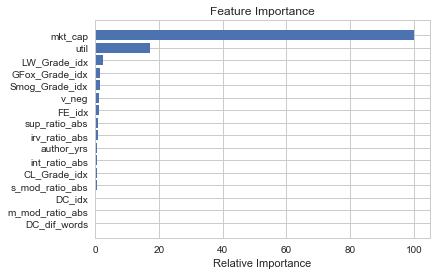

In [281]:
# Feature importance
def plot_importance(clf, X, max_features=10):
    
    '''Plot feature importance'''
    
    feature_importance = clf.feature_importances_
    
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    # Show only top features
    pos = pos[-max_features:]
    feature_importance = (feature_importance[sorted_idx])[-max_features:]
    feature_names = (X.columns[sorted_idx])[-max_features:]
    
#     sns.barplot(x=feature_importance, y=pos, palette="husl", orient='h')
#     ax.set_title('Top 20 Most Productive Authors in SA Short Ideas Section (2012~2015)', fontsize=15)
#     ax.set_xlabel('Number of Articles', fontsize=13)
#     ax.set_ylabel('Author ID', fontsize=13)
#     sns.despine(left=True, bottom=True)

    plt.barh(pos, feature_importance, align='center')
    plt.yticks(pos, feature_names)
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance')
    
#gb_clf_final_model = grid_search.best_estimator_    
plot_importance(gb_clf_final_model, X_columns, max_features=16)    

#### Evaluate final model on the test set

In [249]:
from sklearn.metrics import precision_score, accuracy_score

y_pred = gb_clf_final_model.predict(X_test)
print(gb_clf_final_model.__class__.__name__, precision_score(y_test, y_pred))

GradientBoostingClassifier 0.483821263482


In [250]:
pd.crosstab(y_test, y_pred, margins=True)

col_0,0.0,1.0,All
100d_ret_bi,,,
0.0,344,335,679
1.0,221,314,535
All,565,649,1214


### 3. XGBoost Classifier

* https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
* https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

In [ ]:
Classifier: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

#### *max_depth and min_child_weight*

In [181]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier()
param_grid = {'max_depth': [3, 4, 5], 'min_child_weight': [1, 5, 10]}
grid_search = GridSearchCV(xgb_clf, param_grid, cv=tscv, scoring="precision")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4, 5], 'min_child_weight': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [182]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 10}, 0.55201597469254782)

#### *gamma*

In [245]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier(max_depth=3, min_child_weight=10)
param_grid = {'gamma': [0.5, 1, 1.5, 2, 5]}
grid_search = GridSearchCV(xgb_clf, param_grid, cv=tscv, scoring="precision")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.5, 1, 1.5, 2, 5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='precision',
       verbose=0)

In [184]:
grid_search.best_params_, grid_search.best_score_

({'gamma': 5}, 0.55254657859641632)

#### *subsample and colsample_bytree*

In [185]:
from sklearn.model_selection import GridSearchCV

xgb_clf = XGBClassifier(max_depth=3, min_child_weight=10, gamma=5)
param_grid = {'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}
grid_search = GridSearchCV(xgb_clf, param_grid, cv=tscv, scoring="precision")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [186]:
grid_search.best_params_, grid_search.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.6}, 0.56552730210924518)

#### *Final model*

In [187]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

#### Feature importance of the final model

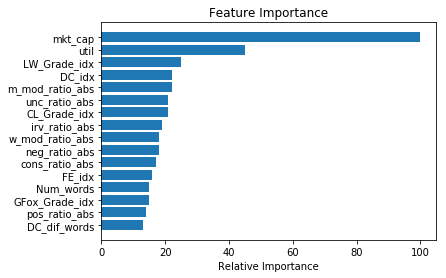

In [188]:
# Feature importance
def plot_importance(clf, X, max_features=10):
    
    '''Plot feature importance'''
    
    feature_importance = clf.feature_importances_
    
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    # Show only top features
    pos = pos[-max_features:]
    feature_importance = (feature_importance[sorted_idx])[-max_features:]
    feature_names = (X.columns[sorted_idx])[-max_features:]
    
    plt.barh(pos, feature_importance, align='center')
    plt.yticks(pos, feature_names)
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Features from XGBoost')
    
xgb_clf_final_model = grid_search.best_estimator_    
plot_importance(xgb_clf_final_model, X_columns, max_features=20)    

#### Evaluate final model on the test set

In [255]:
from sklearn.metrics import precision_score, accuracy_score

y_pred = xgb_clf_final_model.predict(X_test)
print(xgb_clf_final_model.__class__.__name__, precision_score(y_test, y_pred))

XGBClassifier 0.4816


In [256]:
pd.crosstab(y_test, y_pred, margins=True)

col_0,0.0,1.0,All
100d_ret_bi,,,
0.0,355,324,679
1.0,234,301,535
All,589,625,1214


### 4. SVC (Support Vector Classifier)

* https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
* https://www.kaggle.com/jinilcs/grid-search-to-find-best-tuning-parameters

In [ ]:
Classifier: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### C (penalty parameter)

In [232]:
from sklearn.model_selection import GridSearchCV

svm_clf = SVC(probability=True)
param_grid = {'C': [0.5, 1, 10, 100]}
grid_search = GridSearchCV(svm_clf, param_grid, cv=tscv, scoring="precision")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.5, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='precision',
       verbose=0)

In [233]:
grid_search.best_params_, grid_search.best_score_

({'C': 1}, 0.56479310779041925)

#### *Final model*

In [234]:
grid_search.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Feature importance of the final model

: not available for SVC

#### Evaluate final model on the test set

In [257]:
from sklearn.metrics import precision_score, accuracy_score

svm_clf_final_model = grid_search.best_estimator_ 
y_pred = svm_clf_final_model.predict(X_test)
print(svm_clf_final_model.__class__.__name__, precision_score(y_test, y_pred))

SVC 0.47510373444


In [258]:
pd.crosstab(y_test, y_pred, margins=True)

col_0,0.0,1.0,All
100d_ret_bi,,,
0.0,426,253,679
1.0,306,229,535
All,732,482,1214


# Ensemble methods
* Try three different ensemble methods such as hard voting, soft voting and stacking.
* Make predictions on the test set.
* The material in this part borrows heavily from Geron's script https://github.com/ageron/handson-ml/blob/master/07_ensemble_learning_and_random_forests.ipynb

### Hard voting classifier
A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is calle a *hard voting* classifier.

* https://www.kaggle.com/haydenjeune/titanic-voting-classifier-w-cross-validation

In [260]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("logit_clf", logit_clf_final_model),
    ("gb_clf", gb_clf_final_model),
    ("xgb_clf", xgb_clf_final_model),
    ("svm_clf", svm_clf_final_model),
]

In [261]:
voting_clf = VotingClassifier(named_estimators)

In [262]:
display_scores(voting_clf)


Classifier: VotingClassifier(estimators=[('logit_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('gb_cl...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)
Scores: [ 0.46229508  0.225       0.56097561  0.58333333  0.61111111  0.79032258
  0.86363636  0.67241379  0.58064516  0.80672269]
Mean: 0.615645572392
Standard deviation: 0.176958581884
--------------------------------------------------------------------------------


In [263]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('logit_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('gb_cl...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [264]:
# Evaluate on the test set
y_pred = voting_clf.predict(X_test)
print(voting_clf.__class__.__name__, precision_score(y_test, y_pred))

VotingClassifier 0.5


In [265]:
pd.crosstab(y_test, y_pred, margins=True)

col_0,0.0,1.0,All
100d_ret_bi,,,
0.0,452,227,679
1.0,308,227,535
All,760,454,1214


### Soft voting classifier
If all classifiers are able to estimate class probabilities (i.e., they have a predict_proba( ) method), then we can tell Scikit-Learn to predict the class with the highest class probability, averaged over all individual classifiers. This is called *soft voting.*

In [266]:
voting_clf.voting = "soft"

In [267]:
display_scores(voting_clf)


Classifier: VotingClassifier(estimators=[('logit_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('gb_cl...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)
Scores: [ 0.4587156   0.21929825  0.46153846  0.56666667  0.57142857  0.79746835
  0.8556701   0.6375      0.56578947  0.81818182]
Mean: 0.595225729097
Standard deviation: 0.184474137936
--------------------------------------------------------------------------------


In [268]:
# Evaluate on the test set
y_pred = voting_clf.predict(X_test)
print(voting_clf.__class__.__name__, precision_score(y_test, y_pred))

VotingClassifier 0.48


In [269]:
pd.crosstab(y_test, y_pred, margins=True)

col_0,0.0,1.0,All
100d_ret_bi,,,
0.0,406,273,679
1.0,283,252,535
All,689,525,1214
